# Berechnung AOI Heatmaps
### Code zu Abschnitt 4.4

1. Importieren der benötigten Bibliotheken
2. Definition der AOIs
3. Definition der Auswertefunktion
4. Definition zum Einlesen der Transformationsmatrizenwerte
5. Dateipfade einlesen (Abgabeverzeichnis 1_Daten/2_processed)
6. Auswertung ausführen

In [80]:
# Schritt 1: Importieren der benötigten Bibliotheken

import sys
import os
import pandas as pd
import numpy as np
import math
import json

from ipywidgets import interactive, IntSlider, FloatSlider
from IPython.display import display, HTML

sys.path.append('../3_Lib/py')

import matplotlib.pyplot as plt

from helper import AOI
from helper import Intersection
from helper import translate, rotate_x, rotate_y, rotate_z, scale_x, scale_y, scale_z
from helper import plot, plot_with_image, plot_vectors, plot_vectors_with_image, plot_vectors_with_image_and_aois, plot_heatmap
from helper import apply_transformation, normalize, get_all_aois_intersection, set_closest_intersection_and_get_distance, get_gaze_pairs
plt.rcParams["figure.figsize"] = (17, 5) # (w, h)


In [81]:
filename = "../3_Lib/cam_config.json"

matrix_cache = {
    "cam_1": None,
    "cam_2": None,
    "cam_3": None,
    "cam_4": None
}

def fill_matrix_cache():
    with open(filename, 'r') as f:
        config = json.load(f)
        matrix_cache["cam_1"] = get_transformation_matrix("cam_1", config["cam_1"])
        matrix_cache["cam_2"] = get_transformation_matrix("cam_2", config["cam_2"])
        matrix_cache["cam_3"] = get_transformation_matrix("cam_3", config["cam_3"])
        matrix_cache["cam_4"] = get_transformation_matrix("cam_4", config["cam_4"])

def get_transformation_matrix(client_id, config):     
    rot_x = rotate_x(math.radians(config["rot_x"]))
    rot_y = rotate_y(math.radians(config["rot_y"]))
    rot_z = rotate_z(math.radians(config["rot_z"]))

    s_x = scale_x(config["s_x"])
    s_y = scale_y(config["s_y"])
    s_z = scale_z(config["s_z"])

    d = translate(config["t_x"], config["t_y"], config["t_z"])
    
    return scale_x(-1) @ rotate_y(math.radians(-90)) @ d @ s_z @ s_y @ s_x @ rot_z @ rot_y @ rot_x @ scale_y(-1)


fill_matrix_cache()

In [135]:
# Schritt 2:  Definition der AOIs

filename = "../3_Lib/aois.json"

aoi_list = []

def fill_aoi_list():
    with open(filename, 'r') as f:
        aois = json.load(f)
        for aoi in aois:   
            aoi_list.append(AOI(
                [aoi['aoi_x_0'], aoi['aoi_y_0'], aoi['aoi_z_0']], 
                [aoi['aoi_x_1'], aoi['aoi_y_1'], aoi['aoi_z_1']], 
                [aoi['aoi_x_2'], aoi['aoi_y_2'], aoi['aoi_z_2']], 
                [aoi['cross_hair_x'], aoi['cross_hair_y'], aoi['cross_hair_z']], 
                aoi['color'], 
                aoi['name']))

fill_aoi_list()

In [126]:
# Schritt 2:  Definition der AOIs

def get_aois():
    schrank_oben = AOI([0, 320, 80], [800, 320, 80], [0, 496, 80], [0,0,0], 'orange', 'Schrank oben')
    wand = AOI([0, 320, 1], [0, 190, 1], [800, 320, 1], [0,0,0], 'blue', 'Wand zwischen Schränken')
    schrank_unten = AOI([0, 200, 156], [800, 200, 156], [0, 0, 156], [0,0,0], 'white', 'Schrank unten')
    af = AOI([0, 177, 0], [800, 177, 0], [0, 177, 156], [0,0,0], 'green', 'Arbeitsfläche')
    ks = AOI([800, 0, 156], [935, 0, 156], [800, 496, 156], [0,0,0], 'cyan', 'Kühlschrank')
    
    return [schrank_oben, wand, schrank_unten, ks, af]

In [82]:
# Schritt 5: Dateipfade einlesen (Abgabeverzeichnis 1_Daten/2_processed)

# siehe https://stackoverflow.com/questions/19587118/iterating-through-directories-with-python

root = '../1_Daten/2_processed'
FILE_NAMES = []

for subdir, dirs, files in os.walk(root):
    for file in files:
        if 'annotation' not in file or '.csv' not in file:
            continue
        FILE_NAMES.append(os.path.join(subdir, file).replace('\\', '/'))

In [83]:
def filter_data(tester, client_id, position):
    main_frame = pd.DataFrame()

    for f in FILE_NAMES:
        df = pd.read_csv(f, sep=',', engine='python')
        if(position != None):
            df = df[(df['position'] == position)]
        if(client_id != None):
            df = df[(df['client_id'] == client_id)]
        if(tester != None):
            df = df[(df['tester'] == tester)]
        main_frame = main_frame.append(df)

    return main_frame

In [84]:
# Schritt 3:  Definition der Auswertefunktion

def run_aoi_evaluation(aois, transformation_matrix, coordinates, gazes, heatmap_prefix, render):
    # normierte Blickrichtung auf Startkoordinaten addieren
    gaze_ends = np.swapaxes(np.swapaxes(coordinates, 0, 1) + np.swapaxes(gazes, 0, 1) * 10000, 0, 1)
    
    # transformieren
    transformed_coordinates = apply_transformation(coordinates, transformation_matrix, swap=False)
    transformed_gaze_ends = apply_transformation(gaze_ends, transformation_matrix, swap=False)

    # Blickrichtung zurückrechnen und normalisieren
    transformed_directions = transformed_gaze_ends - transformed_coordinates
    transformed_gazes = np.array([normalize(transformed_directions[i]) for i in range(len(transformed_directions))])

    # Intersektion Ojekte erstellen
    intersections = get_all_aois_intersection(transformed_coordinates, transformed_gazes, aois)

    # Kürzeste Entfernung für jeden Punkt
    distances = np.array([set_closest_intersection_and_get_distance(intersections[i]) for i in range(len(intersections))])
    
    detected_aois_with_cross_hair_dist = []
    
    for intersect in intersections:
        for single in intersect:
            if(single.is_hit):
                detected_aois_with_cross_hair_dist.append([single.aoi.title, single.dist_cross_hair_end])
                    
    # Start- und Endpunkte der Blicke (Start = Ende, wenn kein Schnittpunkt => Entfernung INF)
    gaze_starts, gaze_ends = get_gaze_pairs(transformed_coordinates, transformed_gazes, distances)
    
    gaze_starts = np.swapaxes(gaze_starts, 0, 1)
    gaze_ends = np.swapaxes(gaze_ends, 0, 1)
    
    if (render):        
        plot_vectors_with_image_and_aois(gaze_starts, gaze_ends, aois, 'Test', render)
    
    return detected_aois_with_cross_hair_dist

    #for aoi in aois:
        #plot_heatmap(aoi, aoi.title, save=True, filename='%s%s.png' % (heatmap_prefix, aoi.title))
        

In [112]:
def run_evaluation(df, client_id, render):
    coords = np.array([df['eye_l_X'], df['eye_l_Y'], df['eye_l_Z']])
    gazes = np.array([df['gaze_l_X'], df['gaze_l_Y'], df['gaze_l_Z']])
      
    detected_aois_with_cross_hair_dist = run_aoi_evaluation(get_aois(), matrix_cache[client_id], coords, gazes, "path", render)
    
    df = pd.DataFrame(detected_aois_with_cross_hair_dist, columns=["aoi_hits", "dist_to_cross_hair"])
    
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1 = df.aoi_hits.value_counts().plot(kind="bar", ax=ax1)
    ax2 = df.groupby('aoi_hits').sum().plot(kind="bar", ax=ax2)  
        
    display(df.aoi_hits.value_counts().to_frame())        
    display(df.groupby('aoi_hits').mean())

## Evaluierung - Position 1 / cam_2

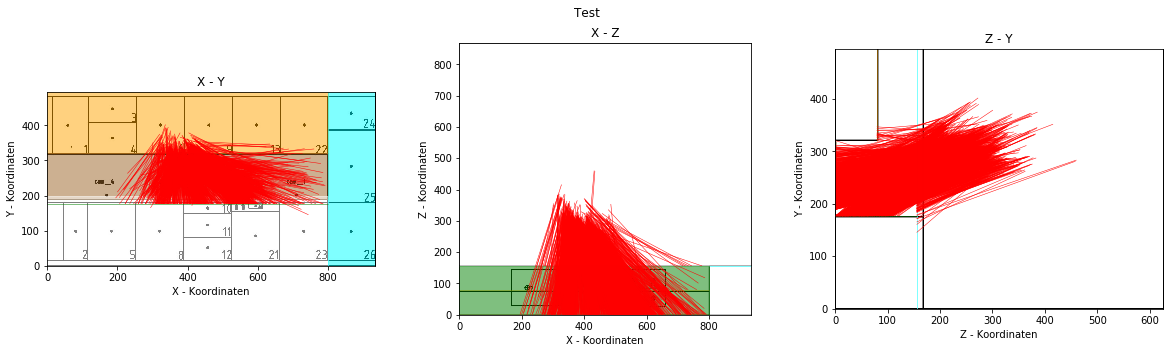

,aoi_hits
Wand zwischen Schränken,1514
Arbeitsfläche,743
Schrank unten,47
Schrank oben,19


,dist_to_cross_hair
aoi_hits,
Arbeitsfläche,503.893245
Schrank oben,666.878466
Schrank unten,487.758016
Wand zwischen Schränken,554.236759


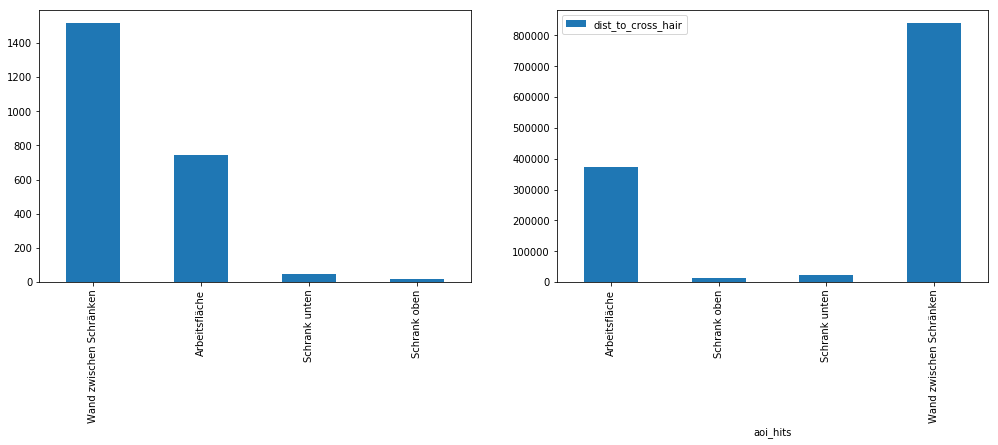

In [127]:
# Alle Daten aller Nutzer an Positon 1 
data = filter_data(None, "cam_2", 1)
run_evaluation(data, "cam_2", True)

## Evaluierung - Position 1 / cam_3

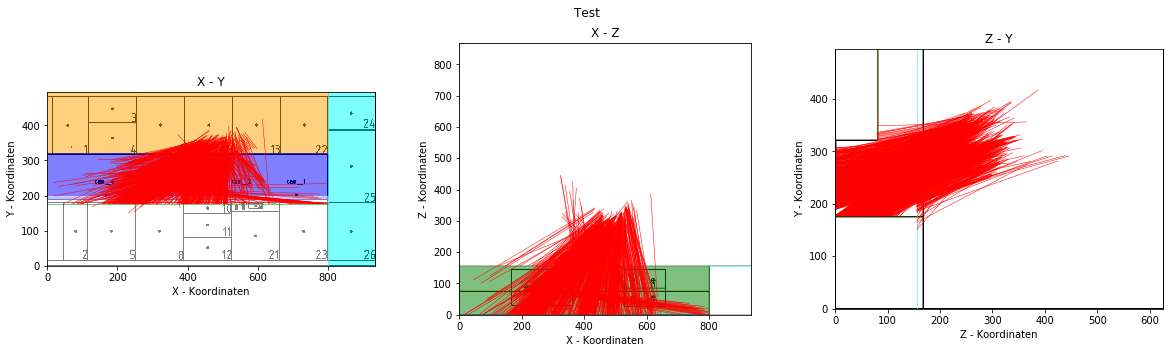

,aoi_hits
Wand zwischen Schränken,625
Arbeitsfläche,540
Schrank unten,37
Schrank oben,15


,dist_to_cross_hair
aoi_hits,
Arbeitsfläche,412.172847
Schrank oben,619.373585
Schrank unten,391.528303
Wand zwischen Schränken,434.829115


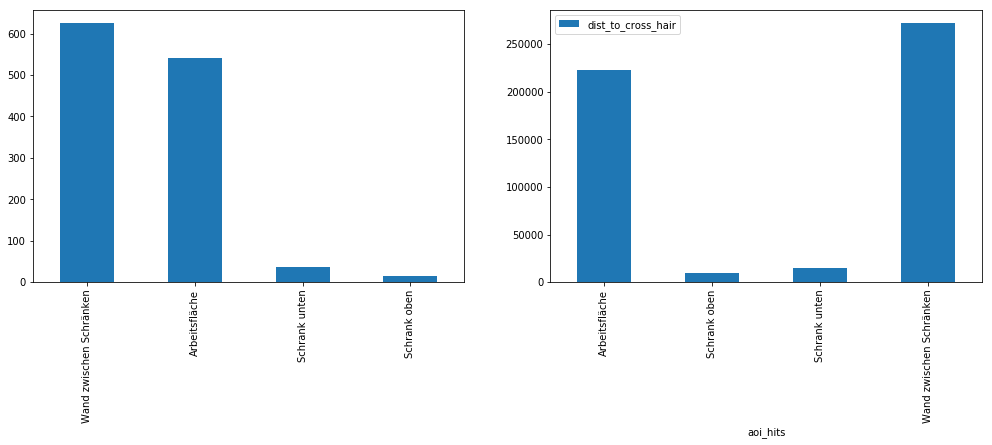

In [114]:
# Alle Daten aller Nutzer an Positon 1 
data = filter_data(None, "cam_3", 1)
run_evaluation(data, "cam_3", True)

## Evaluierung - Position 2 / cam_4

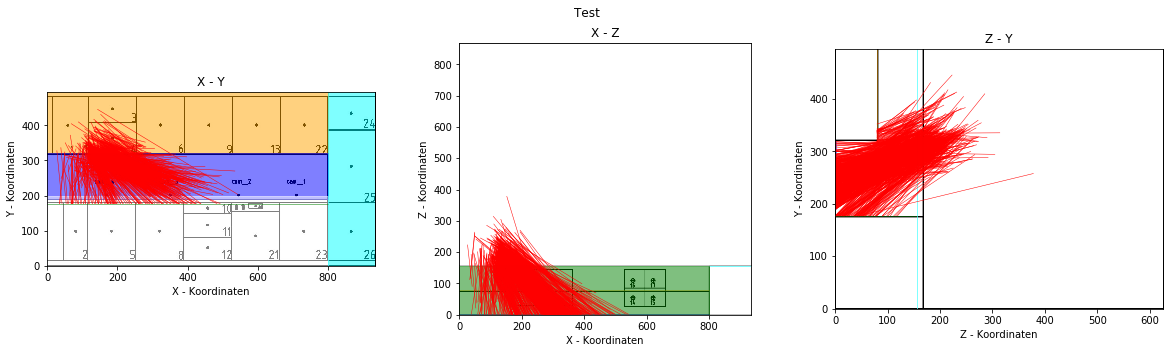

,aoi_hits
Wand zwischen Schränken,629
Arbeitsfläche,130
Schrank oben,42


,dist_to_cross_hair
aoi_hits,
Arbeitsfläche,300.419659
Schrank oben,414.312937
Wand zwischen Schränken,386.435358


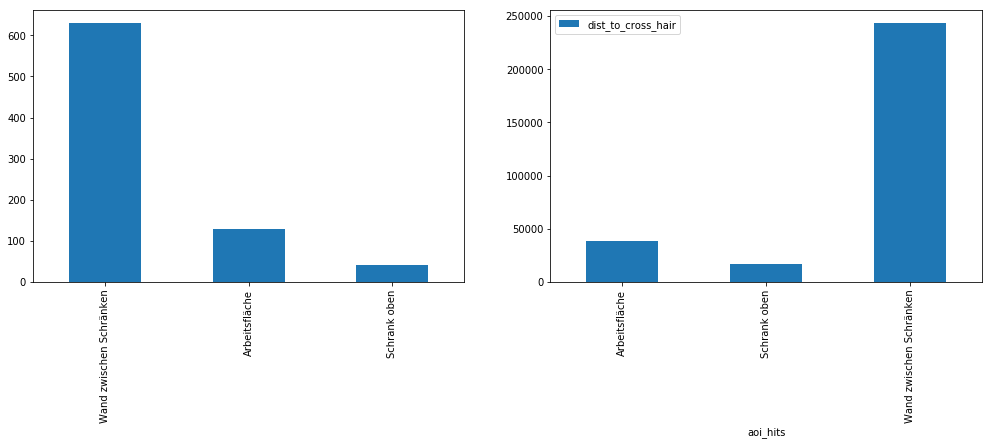

In [115]:
# Alle Daten aller Nutzer an Positon 2 
data = filter_data(None, "cam_4", 2)
run_evaluation(data, "cam_4", True)

## Evaluierung - Position 3 / cam_4

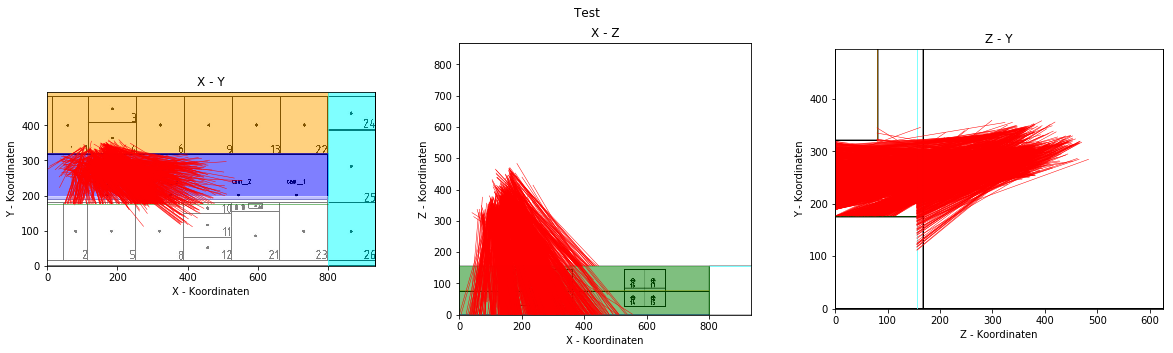

,aoi_hits
Wand zwischen Schränken,968
Arbeitsfläche,384
Schrank unten,150
Schrank oben,8


,dist_to_cross_hair
aoi_hits,
Arbeitsfläche,323.380701
Schrank oben,378.086294
Schrank unten,375.795387
Wand zwischen Schränken,364.654531


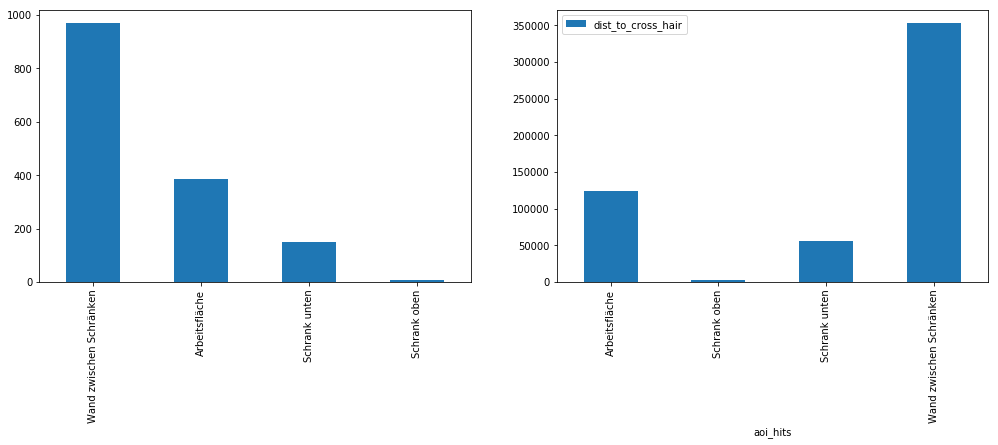

In [116]:
# Alle Daten aller Nutzer an Positon 3 
data = filter_data(None, "cam_4", 3)
run_evaluation(data, "cam_4", True)

## Evaluierung - Position 4 / cam_4

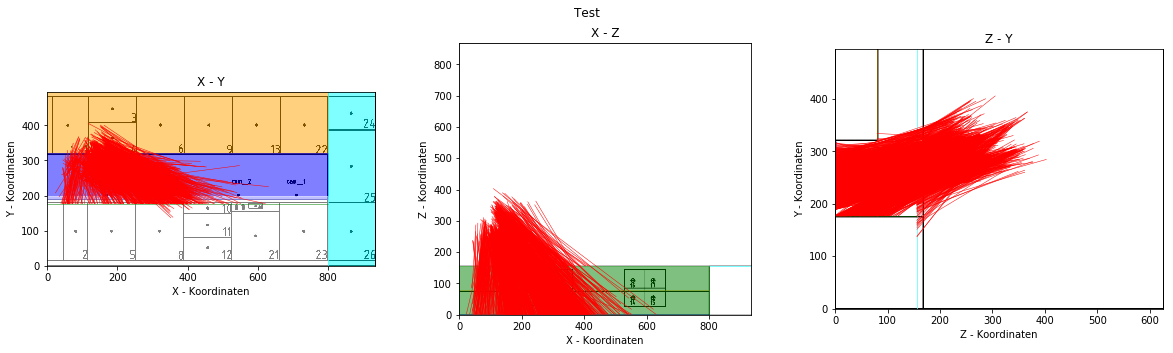

,aoi_hits
Wand zwischen Schränken,1205
Arbeitsfläche,414
Schrank unten,41
Schrank oben,6


,dist_to_cross_hair
aoi_hits,
Arbeitsfläche,339.670396
Schrank oben,375.177181
Schrank unten,390.754657
Wand zwischen Schränken,375.988599


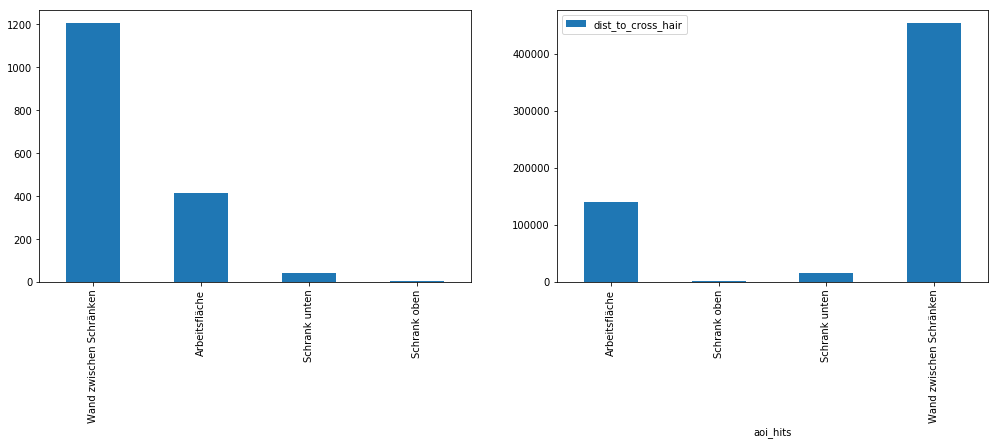

In [117]:
# Alle Daten aller Nutzer an Positon 4 
data = filter_data(None, "cam_4", 4)
run_evaluation(data, "cam_4", True)

## Evaluierung - Position 5 / cam_1

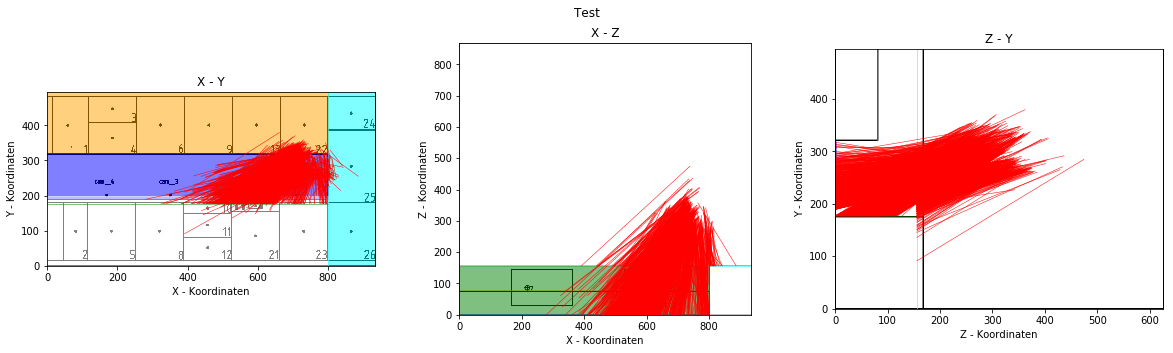

,aoi_hits
Arbeitsfläche,874
Wand zwischen Schränken,851
Schrank unten,167
Kühlschrank,43


,dist_to_cross_hair
aoi_hits,
Arbeitsfläche,612.688687
Kühlschrank,867.151152
Schrank unten,640.296527
Wand zwischen Schränken,640.747006


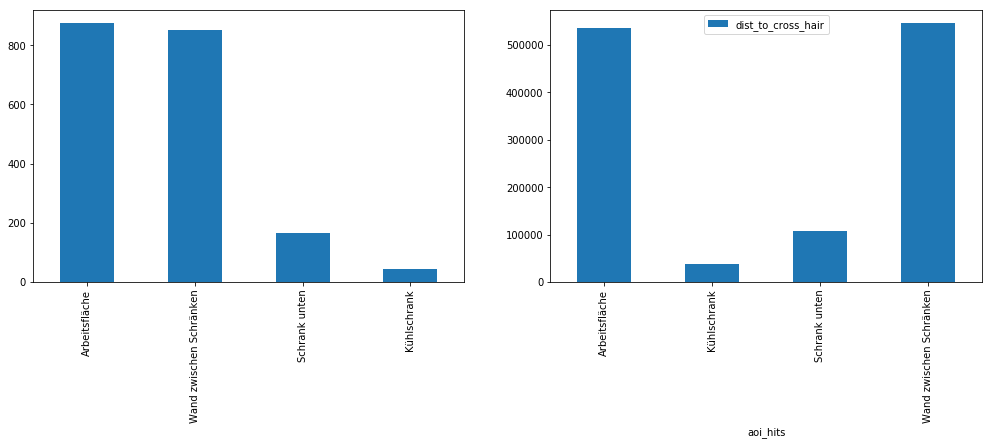

In [118]:
# Alle Daten aller Nutzer an Positon 5
data = filter_data(None, "cam_1", 5)
run_evaluation(data, "cam_1", True)